Import Packages

In [30]:
import os
import scipy
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import PIL
import imghdr
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes

get_YOLO_boxing: imports YOLO boxing coordinates from bounding_boxes.csv as a list

In [ ]:
def get_YOLO_boxing(File_name, image_clean_path, original_x, original_y, nx, ny):
    """
    Imports YOLO boxing coordinates from csv file

    Arguments:
    File_name -- file path
    original_x -- number of horizontal pixels of the photo
    original_y --- number of vertical pixels of the photo
    nx --- number of horizontal grid cells
    ny --- number of vertical gird cells

    Returns: 
    image_id -- library contains (pc,x,y,w,h,grid_x,grid_y)
    pc --- probability score
    x --- x coord of box top left cornor in a grid cell
    y --- y coord of box top left cornor in a grid cell
    w --- width of box
    h --- height of box
    grid_x --- x coord of the grid cell
    gird_y --- y coord of the grid cell
    """
    
    bb_list = []
    with open(File_name) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            bb_list.append(row)

    bb_list.pop(0)

    image_id = {} 
    for j in range(1,9767):
        image_id[j] = []
        image_id[j].append(np.array([0,0,0,0,0,0,0]))

    for i in range(len(bb_list)):
        for j in range(len(bb_list[i])):
            #print(bb_list[i][j])
            bb_list[i][j] = float(bb_list[i][j])
            bb_list[i][0] = int(bb_list[i][0])
            
    for idy in tqdm(image_id.keys()):
        num = []
        for image in bb_list:
            if image[0] == idy:
                # convert to center point
                xc = image[1]+image[3]/2
                yc = image[2]+image[4]/2
                wc = image[3]
                hc = image[4]
                grid_x = np.floor(xc*nx/original_x)
                grid_y = np.floor(yc*ny/original_y)
                # convert to YOLO coordinate
                x = xc*nx/original_x - np.floor(xc*nx/original_x)
                y = yc*ny/original_y - np.floor(yc*ny/original_y)
                w = wc / (original_x/nx)
                h = hc / (original_y/ny)
                # filter with clean image
                clean_image_name = image_clean_path + 'clean' + str(idy).zfill(4) + '.png'
                clean_image = PIL.Image.open(clean_image_name)
                pixels = list(clean_image.getdata())
                clean_width, clean_height = clean_image.size
                pixels = [pixels[i * clean_width:(i + 1) * clean_width] for i in range(clean_height)]
                if pixels[int(yc)][int(xc)] == (0,0,255):
                    num.append(np.array([1, x,y,w,h,grid_x,grid_y]))
                image_id[idy]= num

    return image_id

In [ ]:
my_dict = get_YOLO_boxing("./bounding_boxes.csv",'./images/clean/', 720, 480, 15,10)


In [ ]:
my_dict[7811]

In [ ]:
def get_YOLO_output_layer(image_id,nx,ny,a=1):
    """
    convert output of get_YOLO_boxing into (nx,ny,a*5) flatten layer

    Arguments:
    image_id -- library contains (pc,x,y,w,h,grid_x,grid_y)
    nx --- number of horizontal grid cells
    ny --- number of vertical gird cells
    a --- number of anchor boxes

    Returns: 
    output_layer -- (nx,ny,a*5) flatten layer

    """
    num_of_box = len(image_id)
    output_layer = np.zeros((nx,ny,a*5))
    for i in range(num_of_box):
        if image_id[i][0] != 0:
            grid_x = int(image_id[i][5])
            grid_y = int(image_id[i][6])
            output_layer[grid_x][grid_y] = image_id[i][0:5]
    return output_layer
    

In [ ]:
test_output = get_YOLO_output_layer(my_dict[7811],15,10)
box_coord_dict = {}
for i in range(1,9767):
    box_coord_dict[i] = get_YOLO_output_layer(my_dict[i],15,10)

In [ ]:
np.save('box_coord_dict.npy',  box_coord_dict, allow_pickle = True)  

Starts from Here: 
Load Boxing Matrices (15,10,5)

In [3]:
box_coord_dict_back = np.load('box_coord_dict.npy', allow_pickle = True)

In [6]:
def bb_draw(image_path, yolo_output_layer, original_x = 720, original_y = 480, colors = [(255,0,0)]):
    
    nx,ny,_ = yolo_output_layer.shape
    image = PIL.Image.open(image_path)
    out_boxes = [];
    out_scores = [];
    out_classes = [];
    for i in range(nx):
        for j in range(ny):
            if yolo_output_layer[i][j][0] != 0:
                out_scores.append(yolo_output_layer[i][j][0])
                yolo_x = yolo_output_layer[i][j][1]
                yolo_y = yolo_output_layer[i][j][2]
                yolo_w = yolo_output_layer[i][j][3]
                yolo_h = yolo_output_layer[i][j][4]
                box_x1 = i*(original_x/nx)+yolo_x*(original_x/nx) - (yolo_w*(original_x/nx)/2)
                box_y1 = j*(original_y/ny)+yolo_y*(original_y/ny) - (yolo_h*(original_y/ny)/2)
                box_x2 = box_x1 + yolo_w*(original_x/nx)
                box_y2 = box_y1 + yolo_h*(original_y/ny)
                out_boxes.append(np.array([box_y1, box_x1, box_y2, box_x2]))
                out_classes.append(0)
    #print(box_x1)
    #print(box_y1)
    #print(box_x2)
    #print(box_y2)
    #out_scores = [0.9]
    #out_boxes = [[yolo_x*nx,yolo_y*ny,original_x,original_y]]
    #out_classes = [0]
    class_names = ['rock']
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_path), quality=90)
    # Display the results in the notebook
    output_image = imageio.imread(os.path.join("out", image_path))
    imshow(output_image)

rock 1.00 (600, 152) (720, 282)


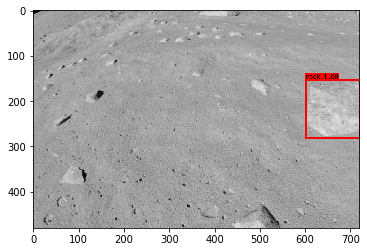

In [14]:
bb_draw('./images/render/render0002.png',box_coord_dict_back.item().get(2))

tuple

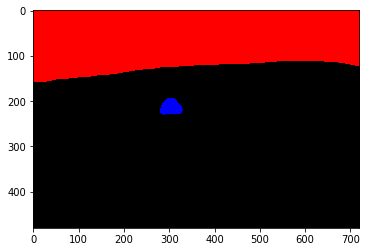

In [12]:
image = PIL.Image.open('./images/clean/clean0001.png')
pixels = list(image.getdata())
width, height = image.size
pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]
imshow(image)
type(pixels[50][50])

In [ ]:
#def batch_boxing(file_path, start_frame, end_frame, original_x, original_y):
#    frame_range = np.arange(start_frame, end_frame+1)
#    for i in tqdm(len(frame_range)):
#        num = str(frame_range)
#        num.zfill(4)
#        file_name = file_path+num
start_frame = 1
end_frame = 9766
file_path = "./images/render/render"
file_ext = ".png"
frame_range = np.arange(start_frame, end_frame+1)
range_length = int(len(frame_range))
for i in tqdm(range(range_length)):
    frame_num = frame_range[i]
    file_name = file_path+str(frame_num).zfill(4)+file_ext
    print(frame_num)
    print(file_name)
    bb_draw(file_name, get_YOLO_output_layer(my_dict[frame_num],15,10))

In [29]:
image, image_data = preprocess_image("./images/render/render0001.png", model_image_size = (608, 608))